# Clustering Chunks
Goals:
- Equal representation of patterns in the ML models
- To figure out more about noisy chunks and ways to throw away. However, there is no "clear" description of what can be attributed as noise. 

In [1]:
%matplotlib inline

from sklearn import cluster
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import scipy.cluster.hierarchy as hac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import common

In [2]:
def distance_func(t1, t2, *args):
    return fastdtw(t1, t2, dist=euclidean)[0]

In [3]:
df = common.load_df("../data/insead", "*.csv")

_cols = ["cwshdr"]
df = common.Process.replace_nulls(df, cols=_cols)
df = common.Process.replace_with_near(df, cols=_cols)
df = common.Process.smooth_data(df, cols=_cols)
df = common.Process.get_normalized_df(df, scale=(0.1, 1), cols=_cols)

sample = df["2016-01":"2016-03"]

In [44]:
# this can be done neatly using pandas..
def create_chunks(df, field="cwshdr"):
    periods = np.unique(df.index.strftime("%Y-%m-%d"))
    print("Total days: ", len(periods))
    
    chunks = []
    size = 20 * 60 # points per day
    for p in periods:
        data = df[field][p:p].values
        if data.shape[0] >= size:
            chunks.append(data[:size])

    return np.array(chunks)

chunks = create_chunks(sample)
chunks.shape
# d = pd.DataFrame({"A": [np.nan, 1,2,3,np.nan, 4, np.nan, np.nan]})
# d.index = [dt.datetime(2017, 1, i+1) for i in range(d.shape[0])]
# create_chunks(d, "A")

Total days:  91


(91, 1200)

In [45]:
cluster = hac.fclusterdata(chunks, 1.0, metric=distance_func)
cluster

array([ 8, 39,  1, 49, 17, 17,  5,  6, 37,  5, 33,  5, 18,  4,  7, 17,  2,
       21, 35, 47,  5, 23,  2, 10, 16,  7, 51, 24, 13, 11, 14, 38, 28, 31,
        6, 30,  4, 34, 50, 45, 26, 11, 48, 17, 18, 17, 15,  1,  8, 52, 12,
        8, 20, 40, 22, 44, 53,  8, 12, 13, 12, 12,  7, 10, 17, 18, 18, 19,
       27, 36, 29, 13, 32, 17, 42, 25,  9,  9,  9, 46,  3,  3, 43,  3, 41,
        8, 11,  5, 11, 11, 13], dtype=int32)

In [47]:
import pickle
with open("../output/fclusterdata.pickle", "wb") as fp:
    pickle.dump(cluster, fp)

In [53]:
with open("../output/fclusterdata.pickle", "rb") as fp:
    cluster = pickle.load(fp)

In [70]:
cluster_df = pd.DataFrame({"Cluster": cluster, "Chunk": range(chunks.shape[0])})
grouped_chunks = cluster_df.groupby(["Cluster"]).apply(lambda x: x.Chunk.values)
grouped_chunks

Cluster
1                        [2, 47]
2                       [16, 22]
3                   [80, 81, 83]
4                       [13, 36]
5             [6, 9, 11, 20, 87]
6                        [7, 34]
7                   [14, 25, 62]
8            [0, 48, 51, 57, 85]
9                   [76, 77, 78]
10                      [23, 63]
11          [29, 41, 86, 88, 89]
12              [50, 58, 60, 61]
13              [28, 59, 71, 90]
14                          [30]
15                          [46]
16                          [24]
17    [4, 5, 15, 43, 45, 64, 73]
18              [12, 44, 65, 66]
19                          [67]
20                          [52]
21                          [17]
22                          [54]
23                          [21]
24                          [27]
25                          [75]
26                          [40]
27                          [68]
28                          [32]
29                          [70]
30                          [35]
31

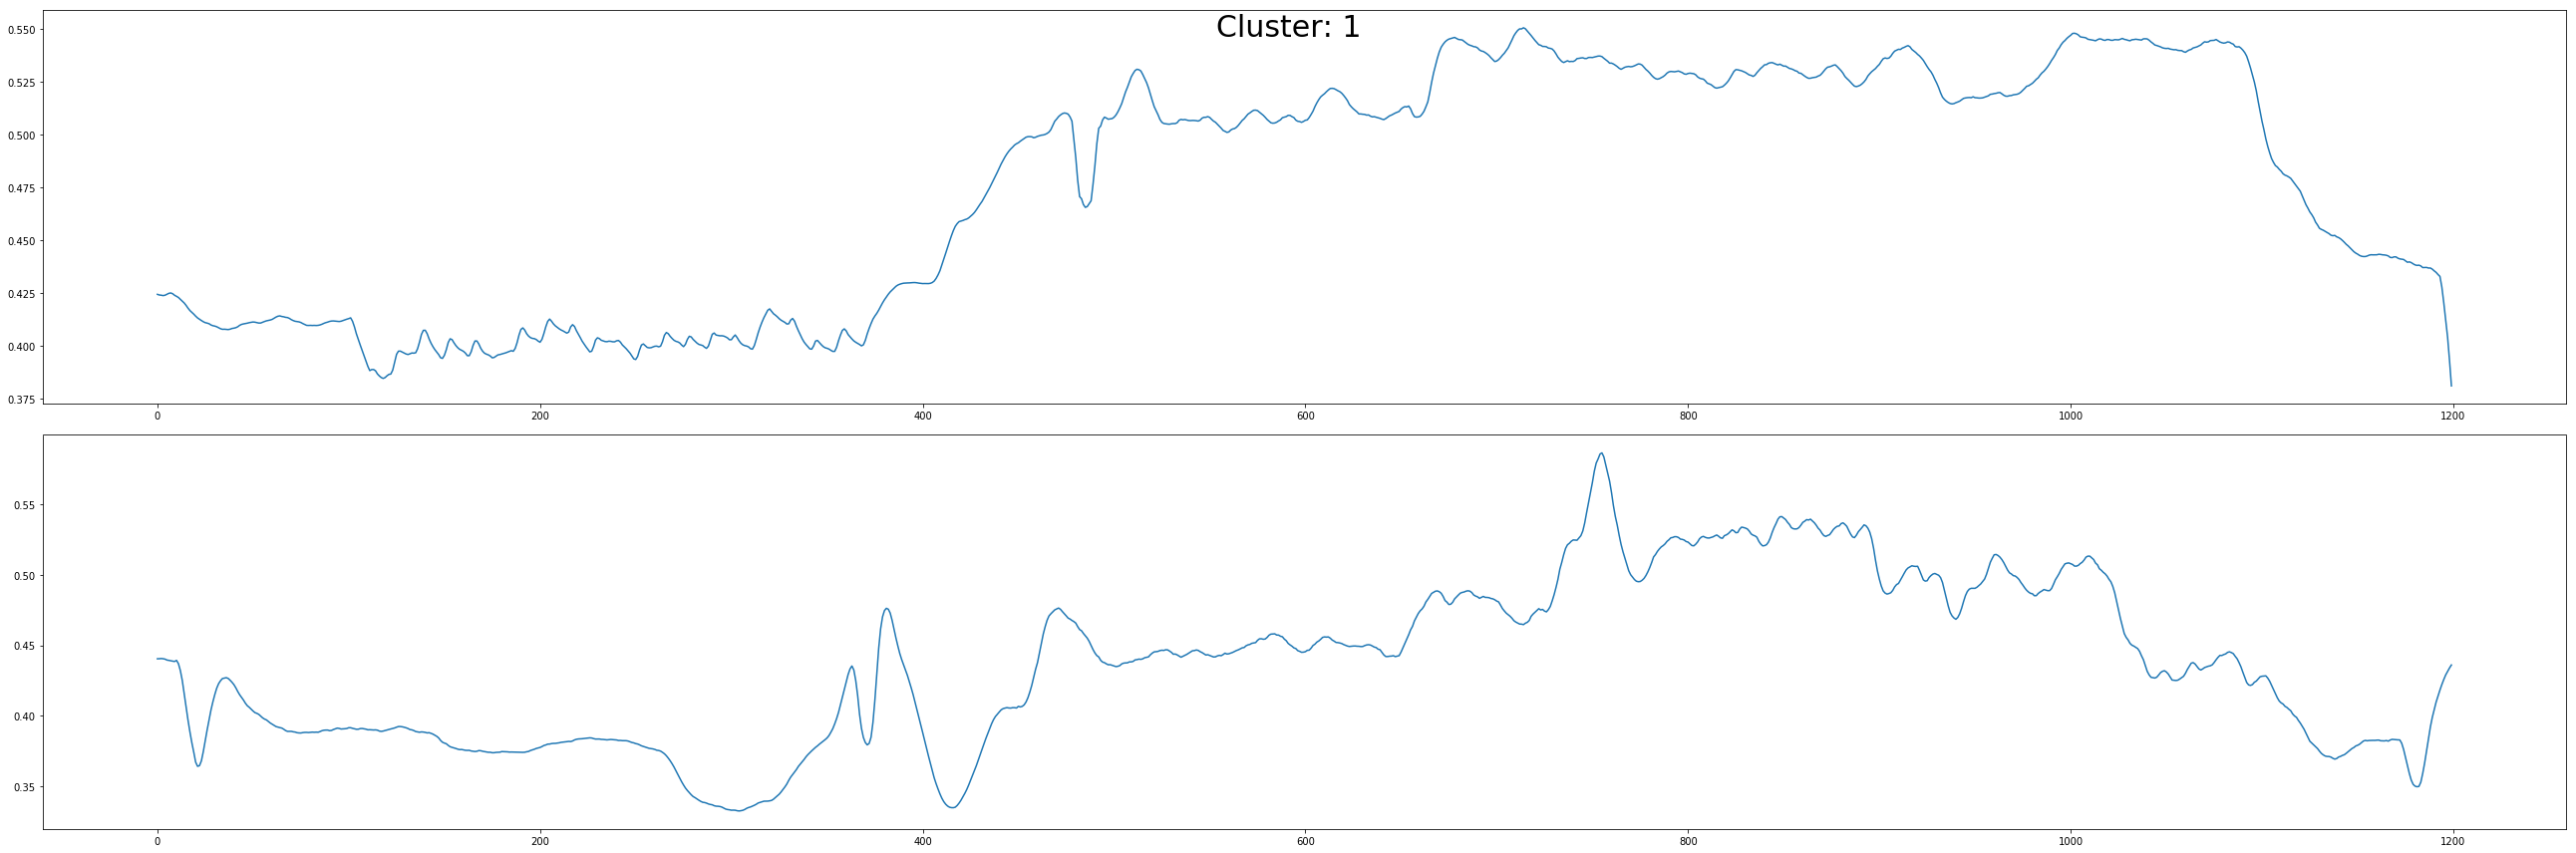

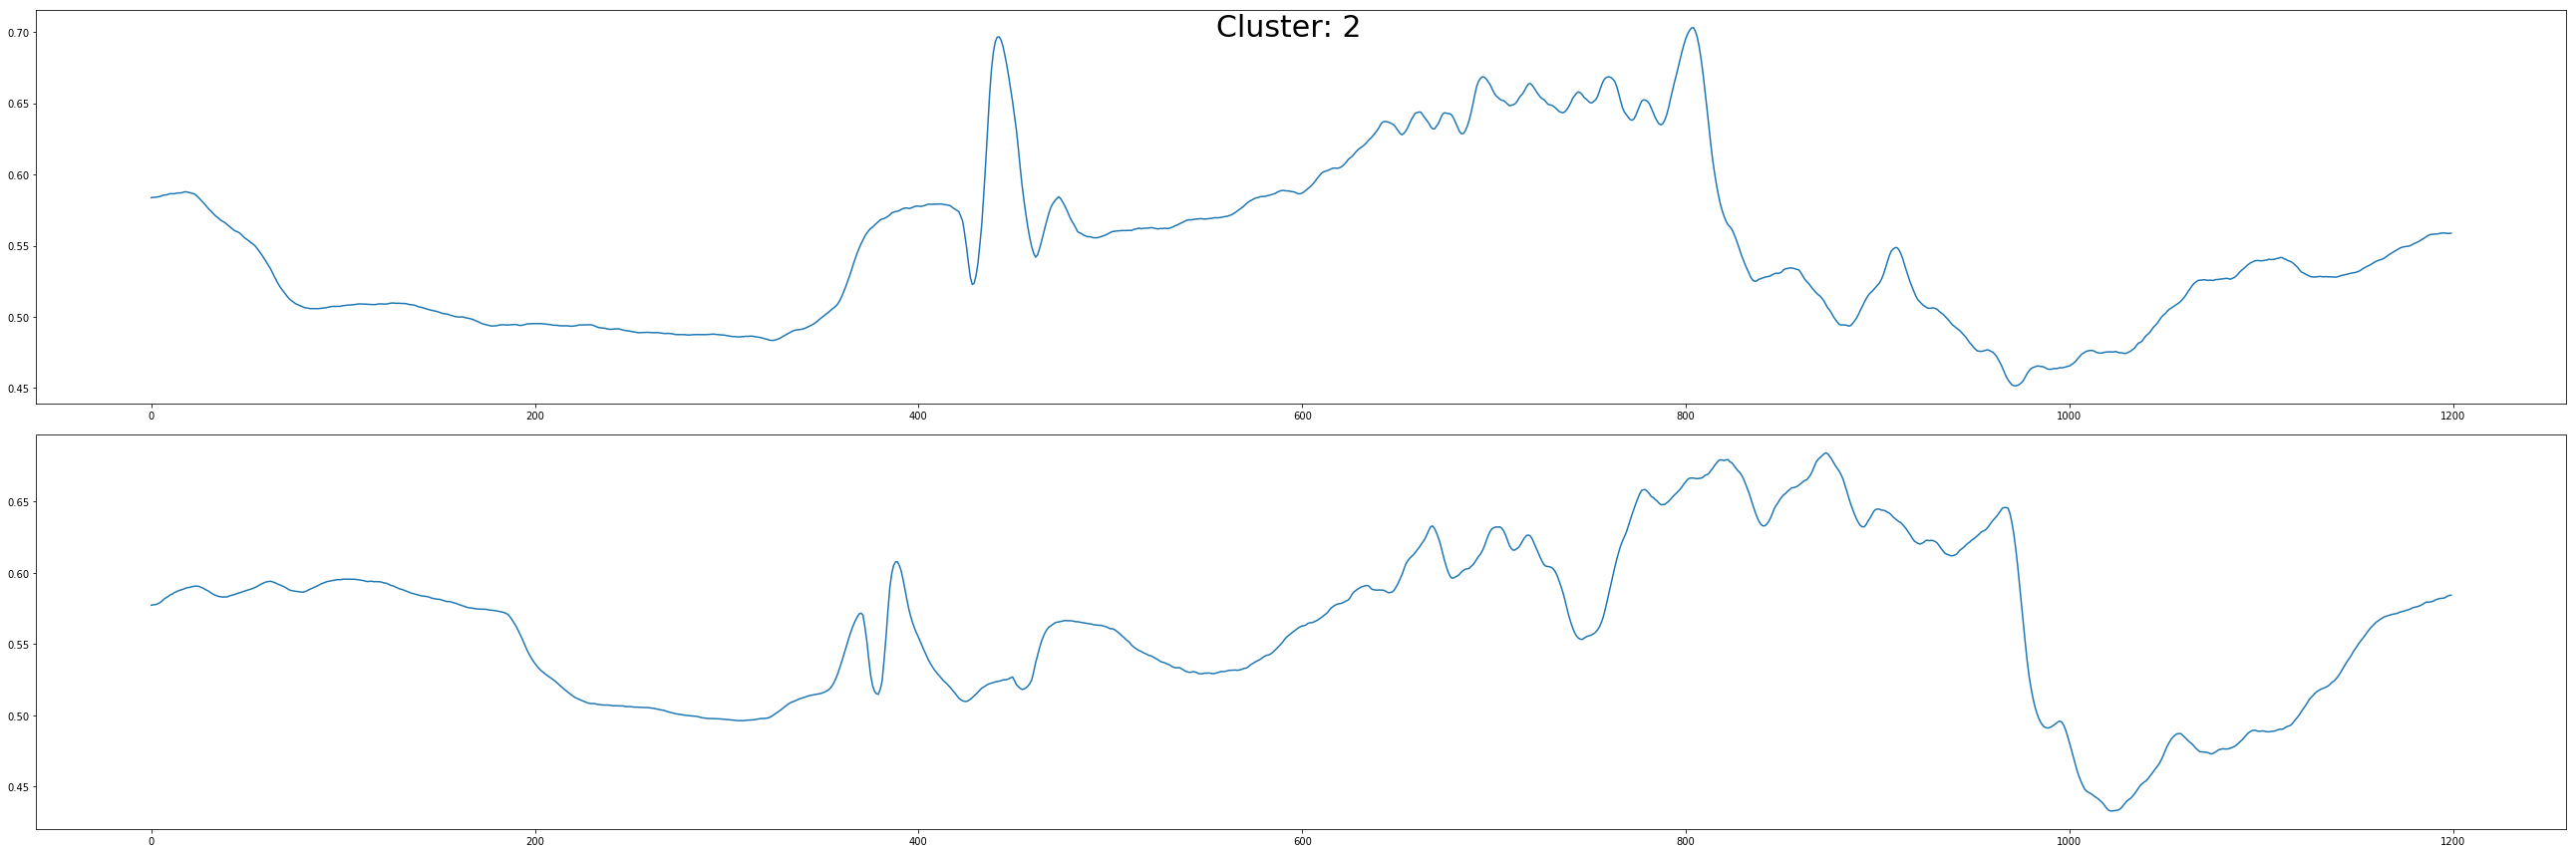

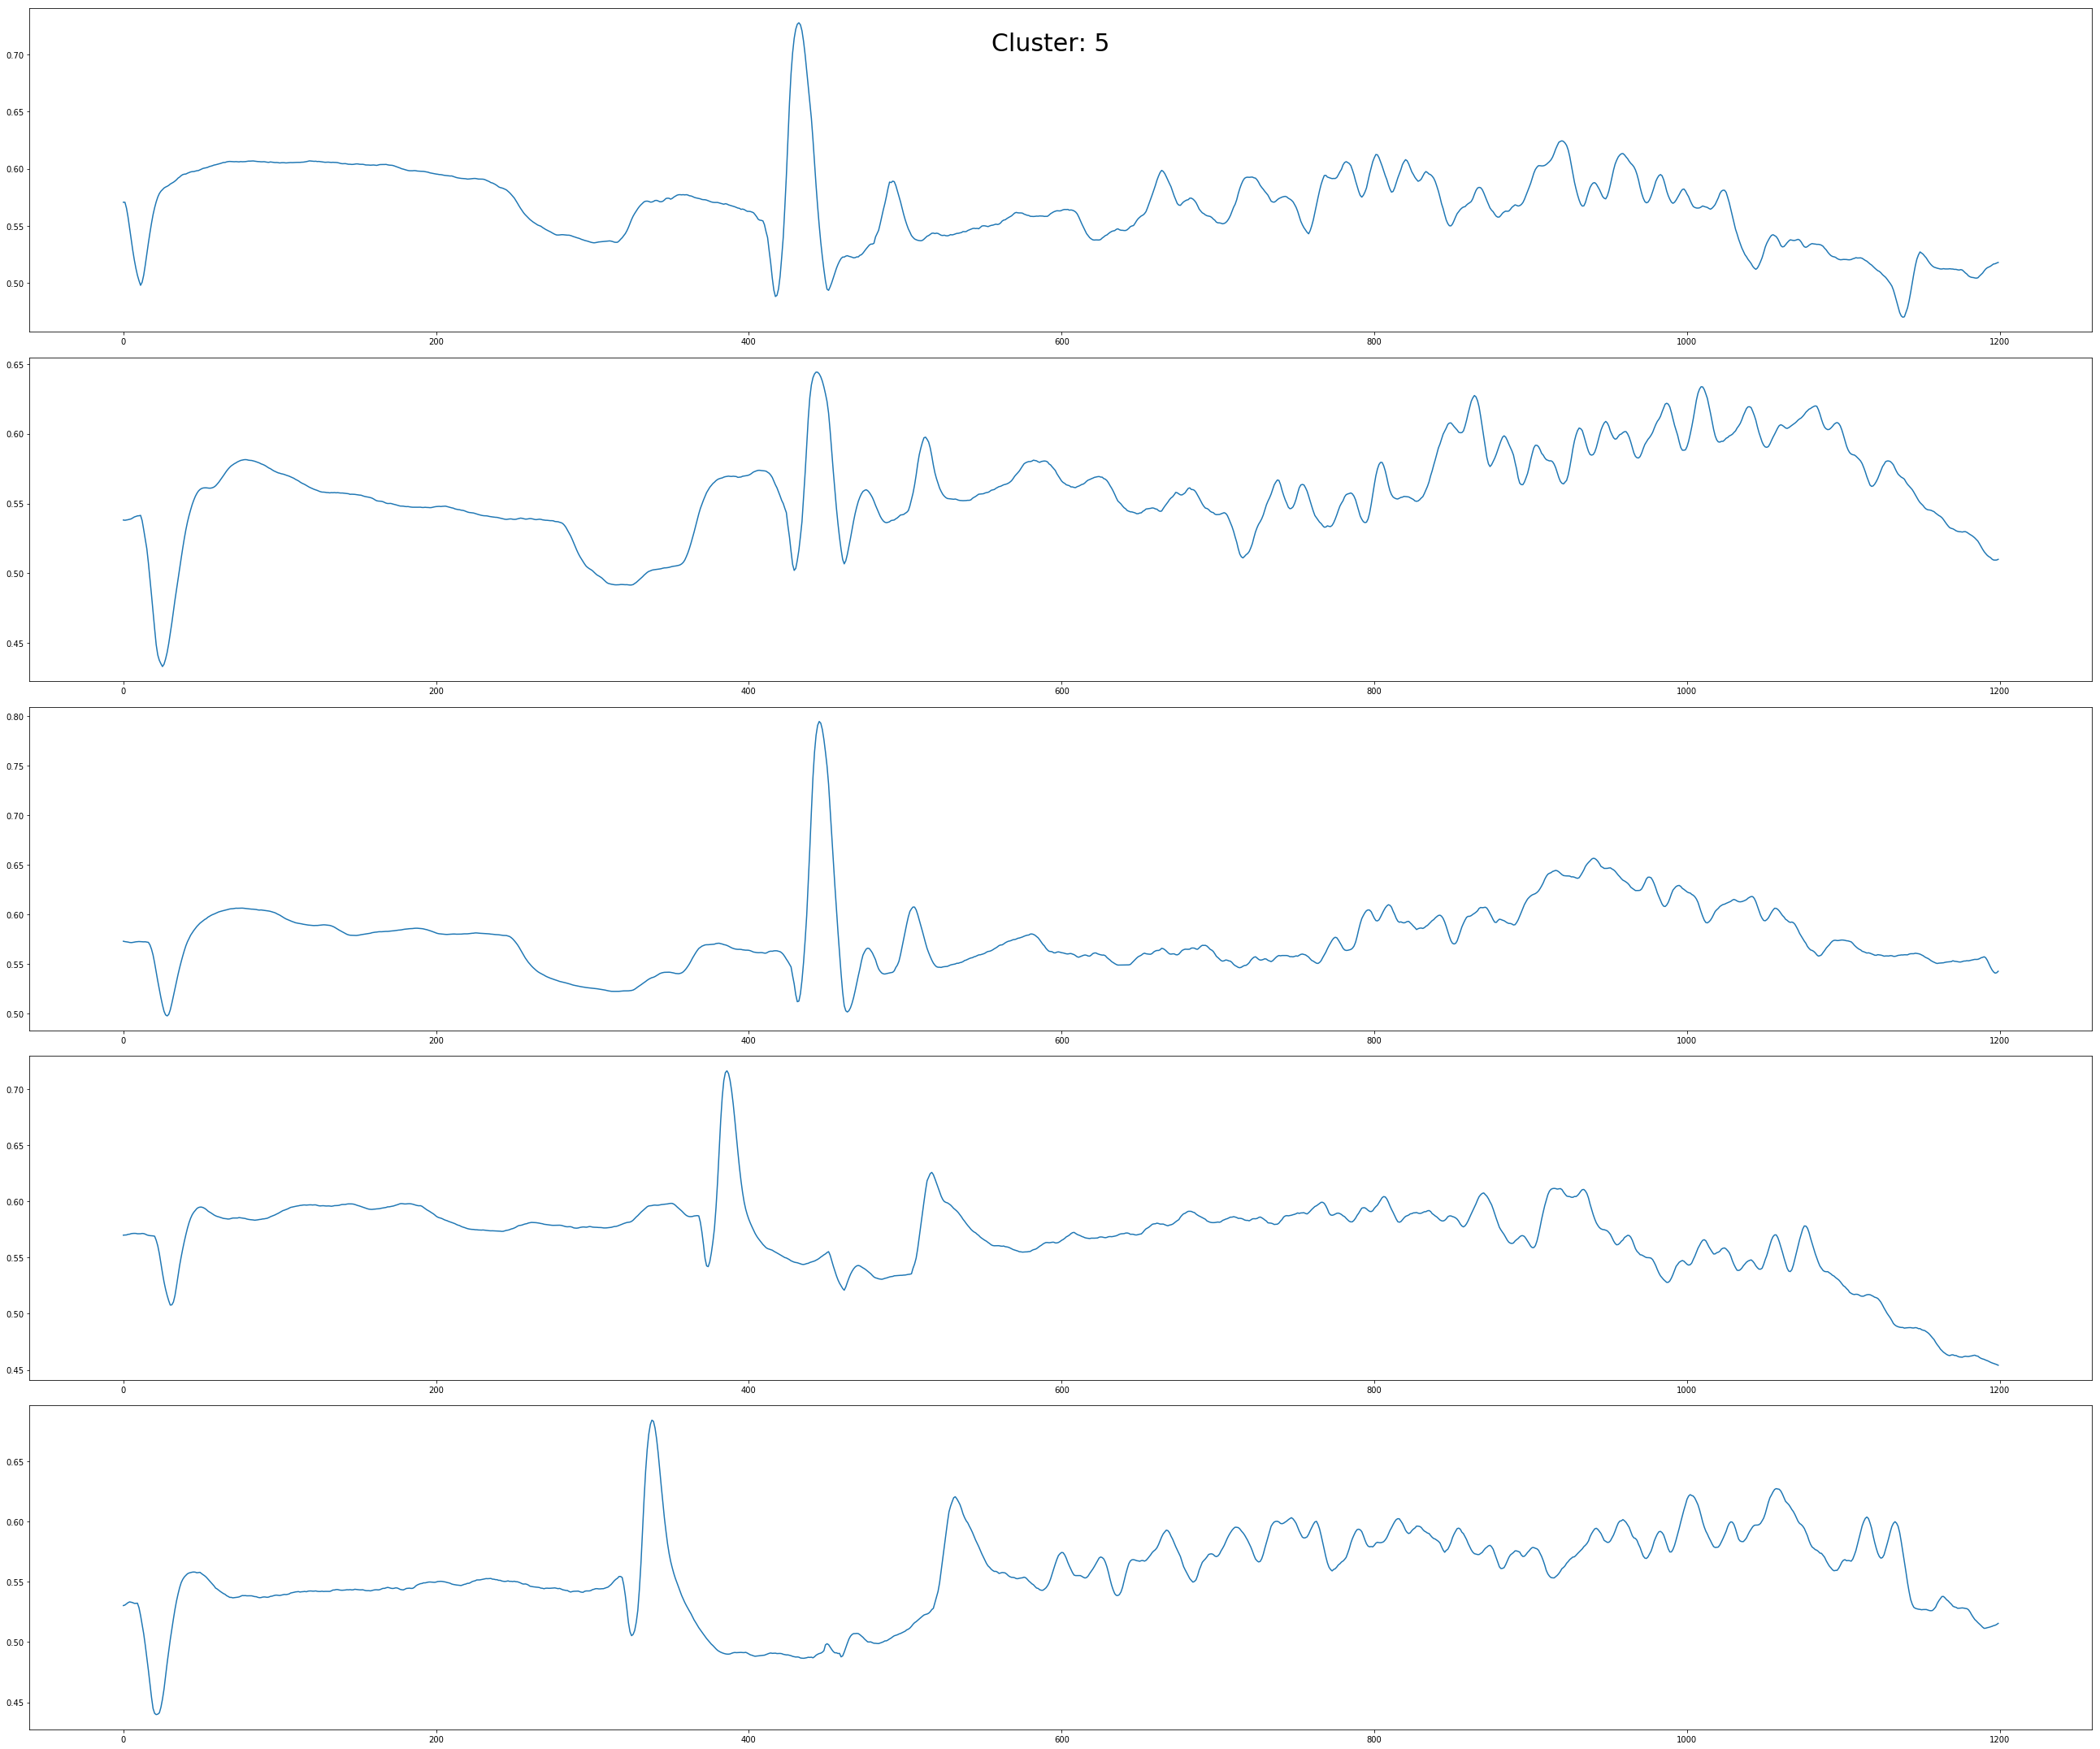

In [87]:
# Look at chunks of a cluster.. 
cluster_ids = [1, 2, 5]
for i in cluster_ids:
    chunk_ids = grouped_chunks[i]
    cnt = chunk_ids.shape[0]
    fig, ax = plt.subplots(cnt, 1, figsize=(36, 6*cnt))
    fig.suptitle("Cluster: {}".format(i), fontsize=30)
    for idx, j in enumerate(chunk_ids):
        ax[idx].plot(chunks[j])
    fig.tight_layout()